# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from time import time

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

в некоторых признаках встречаются пропуски, обработаем их, где возможно

Такие признаки, как DateCrawled, DateCreated, LastSeen, NumberOfPictures и PostalCode не влияют на стои мость автомобиля, можем их удалить. 

In [6]:
data = data.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


проверим полные дубликаты, так как признаков стало меньше 

In [7]:
data.duplicated().sum()

27543

полные дублдикаты ценности для модели не ненсут, удалим их

In [8]:
data = data.drop_duplicates(keep='first')
data.duplicated().sum()

0

Проверим наличие дубликатов в столбцах с категориальными значениями, поскольку чяисла могут повторяться

In [9]:
objects = ["VehicleType","Gearbox","Model","FuelType","Brand", "Repaired"]
for column in objects:
    print(column, data[column].unique())

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox ['manual' 'auto' nan]
Model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

In [10]:
objects = ["VehicleType","Gearbox","Model","FuelType","Brand", "Repaired"]
for column in objects:
    print(column, pd.Series(data[column].unique()).duplicated().sum())

VehicleType 0
Gearbox 0
Model 0
FuelType 0
Brand 0
Repaired 0


дубликатов нет, но в столбце Repaired встречаются пропуски, возможно, этот признак не заполняли те, кто не делали ремонт

In [11]:
data["Repaired"] = data["Repaired"].fillna("no")
data["Repaired"].unique()

array(['no', 'yes'], dtype=object)

в других признаках пропуски оставим, так как их много и заполнение ил удаление может сильно исказить данные

In [12]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,326826.000000,326826.000000,326826.000000,326826.000000,326826.000000
mean,4403.747330,2004.230985,110.244705,128144.073605,5.696239
std,4518.209808,91.120018,195.886373,37947.663920,3.724122
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


В RegistrationYear есть явные аномальные значения, года из будущего и года, когда не было интернета, в RegistrationMonthRegistrationMonth встречается 0, хотя такого месяца нет

In [13]:
data = data[(data['RegistrationYear'] > 1969) & (data['RegistrationYear'] <= 2016) & (data['RegistrationMonth'] > 0)]
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,280769.000000,280769.000000,280769.000000,280769.000000,280769.000000
mean,4730.248945,2002.873344,115.653847,128193.532762,6.377688
std,4608.899209,6.315810,185.209922,36986.897406,3.347357
min,0.000000,1970.000000,0.000000,5000.000000,1.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,4.000000
50%,3000.000000,2003.000000,107.000000,150000.000000,6.000000
75%,6900.000000,2007.000000,143.000000,150000.000000,9.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000


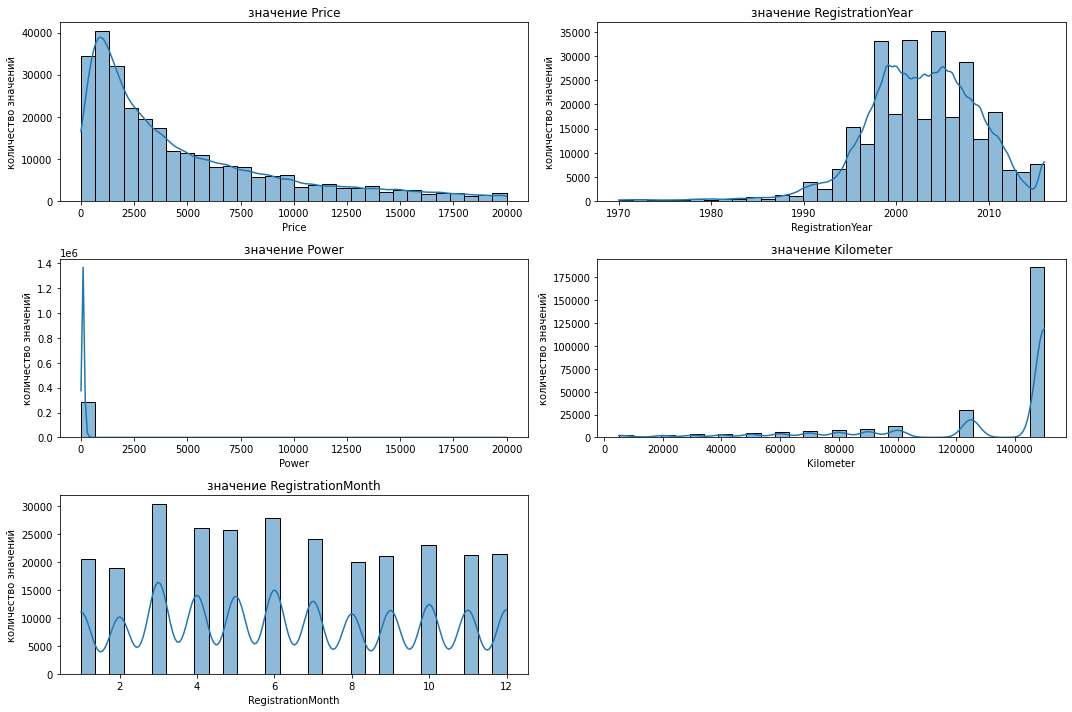

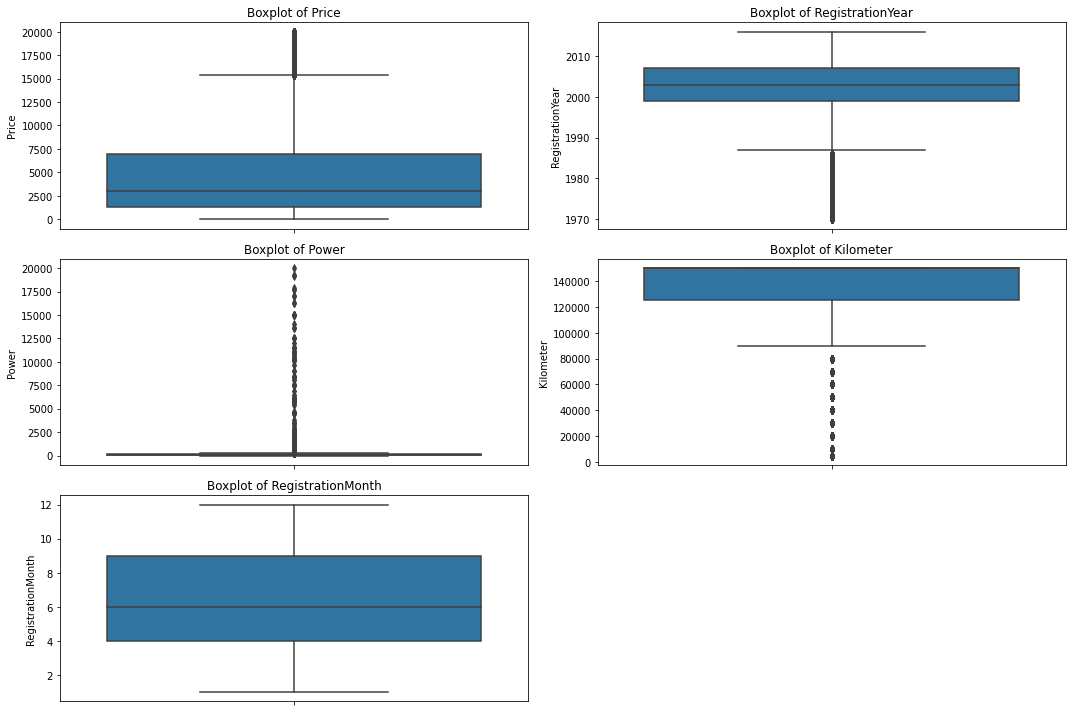

In [14]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'], 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[column], bins=30, kde=True) 
    plt.title(f'значение {column}')
    plt.xlabel(column)
    plt.ylabel('количество значений')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, column in enumerate(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'], 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

почти во всех признаках имеются выбросы, оджнако такие могут встретиться и в реальности. Убавим количество выбросов в power, значения довольно аномальные для признака, и выбросов слишком много. Ограничимся 1000 лошадиными силами, более мощные машины сложно встретить в интернет магазинах. Так как сервис все таки по продаже машин, цена должна быть больше нуля. 

0 л.с.: Это аномалия. Автомобили с нулевой мощностью не существуют, так как это физически невозможно для транспортных средств. Это, скорее всего, ошибка ввода данных или пропуски, обозначенные нулём.
    
1–2 л.с.: Теоретически, существуют транспортные средства с очень низкой мощностью (например, мопеды, электроскутеры), но для автомобилей, продаваемых по объявлениям, 1–2 л.с. крайне маловероятны. Типичные легковые автомобили имеют мощность от 50 л.с. и выше.
    
20–40 л.с.: Такие значения возможны для старых или малолитражных автомобилей (например, Fiat Panda, Citroën 2CV), но они редки в современных объявлениях. В датасете такие значения находятся в нижнем квартиле и могут быть реальными.
    
Вывод: Значения 0 л.с. и 1–2 л.с. являются аномалиями и подлежат удалению или замене. Значения 20–40 л.с. могут быть допустимы, но нужно установить разумный минимальный порог (возьмем 30 л.с.) на основе контекста автомобильного рынка.

Цены 1, 2, 50, 100 евро:

Такие низкие цены маловероятны для автомобилей в реальных объявлениях. 

    1–2 евро: Это нереалистично, так как даже старые автомобили в плохом состоянии обычно стоят не менее нескольких сотен евро.

    50–100 евро: Это может быть возможно для автомобилей на запчасти или в очень плохом состоянии, но такие случаи 
    Установим минимальный порог для Price 200 евро, чтобы исключить аномально низкие цены, которые не отражают рыночные реалии. 

In [15]:
data['Power'].describe()

count    280769.000000
mean        115.653847
std         185.209922
min           0.000000
25%          75.000000
50%         107.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [16]:
data = data[(data['Power'] >= 30) & (data['Power'] < 1000)]
data = data[(data['Price'] > 200)]

data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,251282.000000,251282.000000,251282.000000,251282.000000,251282.000000
mean,5062.082744,2003.132887,122.160553,127923.150086,6.380827
std,4648.744483,6.115241,54.409268,36675.165285,3.345613
min,202.000000,1970.000000,30.000000,5000.000000,1.000000
25%,1499.000000,1999.000000,80.000000,125000.000000,4.000000
50%,3450.000000,2003.000000,115.000000,150000.000000,6.000000
75%,7300.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2016.000000,999.000000,150000.000000,12.000000


Итак, мы избавились от явных аномалий в данных, выбросы есть, но могут встретиться и в реальности. 


Датасет включает 5 числовых столбцов (Price, RegistrationYear, Power, Kilometer, RegistrationMonth) и 6 категориальных (VehicleType, Gearbox, Model, FuelType, Brand, Repaired). Первичный анализ показал, что числовые столбцы содержат аномалии:

- Price: Минимальная цена 0 евро, что нереалистично для автомобилей.
- Power: Минимальная мощность 0 л.с. и максимальная 20,000 л.с. — явные ошибки.
- RegistrationYear: Диапазон от 1000 до 9999, что включает некорректные значения.
- RegistrationMonth: Нулевые значения недопустимы, так как месяц должен быть от 1 до 12.
- Kilometer: Диапазон значений выглядит правдоподобным для подержанных автомобилей.

    Мы проверили датасет на наличие полных дубликатов с помощью .duplicated(). Полные дубликаты были удалены, чтобы избежать искажений в обучении моделей.
    Для числовых столбцов мы применили фильтры:

- Price: Установили минимальный порог 200 евро, чтобы исключить нереалистичные цены (0–100 евро), которые могут быть ошибками ввода или машинами на запчасти. 
- Power: Ограничили мощность диапазоном (30, 1000) л.с. Нулевые и экстремально высокие значения (например, 20,000 л.с.) — это аномалии, а значения < 30 л.с. редки для подержанных автомобилей.
- RegistrationYear: Установили диапазон [1970, 2016], чтобы исключить ошибочные годы .
- RegistrationMonth: Удалили строки с нулевым месяцем, так как это ошибка.


In [18]:
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [19]:
for col in categorical_cols:
    data[col] = data[col].fillna('unknown').astype(str)

In [20]:
data_catboost = data.copy()

X = data.drop('Price', axis=1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_catboost = data_catboost.drop('Price', axis=1)
y_catboost = data_catboost['Price']
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_catboost, y_catboost, test_size=0.25, random_state=42)


cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
missing_cat_features = [col for col in cat_features if col not in X_catboost.columns]
numeric_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') 
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

encoded_columns = encoder.get_feature_names(categorical_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoded_columns, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=encoded_columns, index=X_test.index)

scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric = scaler.transform(X_test[numeric_cols])

X_train_numeric_df = pd.DataFrame(X_train_numeric, columns=numeric_cols, index=X_train.index)
X_test_numeric_df = pd.DataFrame(X_test_numeric, columns=numeric_cols, index=X_test.index)

X_train = pd.concat([X_train_numeric_df, X_train_cat_df], axis=1)
X_test = pd.concat([X_test_numeric_df, X_test_cat_df], axis=1)

обработали дубликаты, пропуски и аномалии в данных, подготовили тернировочную и тестовую выборки. Для catboost подготовили отьдельные выборки, поскольку 

## Обучение моделей

In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
results = {}

In [22]:
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
lr_rmse_cv = np.sqrt(-lr_scores.mean())
start_time = time()
lr_model.fit(X_train, y_train)
lr_train_time = time() - start_time
start_time = time()
y_pred_lr_train = lr_model.predict(X_train)
lr_pred_time = time() - start_time

results['Linear Regression'] = {
    'rmse_cv': lr_rmse_cv,
    'train_time': lr_train_time,
    'pred_time': lr_pred_time
}
print(f"RMSE: {lr_rmse_cv:}, Время обучения: {lr_train_time:}с, Время предсказания: {lr_pred_time:}с")

RMSE: 260394899158.77246, Время обучения: 23.375666618347168с, Время предсказания: 0.2050788402557373с


In [30]:
lgb_model = lgb.LGBMRegressor(random_state=42)
start_time = time()
lgb_model.fit(X_train, y_train)
lgb_train_time = time() - start_time
start_time = time()
y_pred_lgb_train = lgb_model.predict(X_train)
lgb_pred_time = time() - start_time
lgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [7, -1]}
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X_train, y_train)
lgb_rmse_cv = np.sqrt(-lgb_grid.best_score_)

results['LightGBM'] = {
    'rmse_cv': lgb_rmse_cv,
    'train_time': lgb_train_time,
    'pred_time': lgb_pred_time
}
print(f"RMSE: {lgb_rmse_cv:}, Время обучения: {lgb_train_time:}с, Время предсказания: {lgb_pred_time:}с")
print(f"Лучшие параметры: {lgb_grid.best_params_}")

RMSE: 1607.4664620748676, Время обучения: 6.598146677017212с, Время предсказания: 2.604583263397217с
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200}


In [31]:
cb_model = cb.CatBoostRegressor(cat_features=categorical_cols, random_state=42, verbose=0)
start_time = time()
cb_model.fit(X_train_cb, y_train_cb)
cb_train_time = time() - start_time
start_time = time()
y_pred_cb_train = cb_model.predict(X_train_cb)
cb_pred_time = time() - start_time
cb_params = {'iterations': [100, 200], 'learning_rate': [0.05, 0.1], 'depth': [6, 8]}
cb_grid = GridSearchCV(cb_model, cb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cb_grid.fit(X_train_cb, y_train_cb)
cb_rmse_cv = np.sqrt(-cb_grid.best_score_)

results['CatBoost'] = {
    'rmse_cv': cb_rmse_cv,
    'train_time': cb_train_time,
    'pred_time': cb_pred_time
}
print(f"RMSE: {cb_rmse_cv:}, Время обучения: {cb_train_time:}с, Время предсказания : {cb_pred_time:}с")
print(f"Лучшие параметры: {cb_grid.best_params_}")

RMSE: 1617.4855039964787, Время обучения: 175.6568205356598с, Время предсказания : 1.3535609245300293с
Лучшие параметры: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}


## Анализ моделей

In [32]:
comparison_df = pd.DataFrame(results).T
comparison_df

,rmse_cv,train_time,pred_time
Linear Regression,2.603949e+11,23.375667,0.205079
LightGBM,1.607466e+03,6.598147,2.604583
CatBoost,1.617486e+03,175.656821,1.353561


- Линейная регрессия:
RMSE крайне высокое, что указывает на плохое качество предсказаний. Это делает модель непригодной, несмотря на быстрое время обучения (23.38 с) и предсказания (0.21 с).
- LightGBM:
RMSE = 1607.47 — лучший результат, значительно ниже порога 2500.
Время обучения: 6.60 с — самое быстрое среди всех моделей.
Время предсказания: 2.60 с — медленнее, чем у линейной регрессии и CatBoost, но всё ещё приемлемо.
- CatBoost:
RMSE = 1617.49 — чуть хуже, чем у LightGBM, но всё ещё ниже порога 2500.
Время обучения: 175.66 с — значительно дольше, чем у LightGBM, что может быть критичным для больших датасетов.
Время предсказания: 1.35 с — быстрее, чем у LightGBM, но разница небольшая.
- Выбор лучшей модели
Лучшая модель: LightGBM

In [35]:
best_model = lgb.LGBMRegressor(random_state=42, learning_rate=0.1, max_depth=-1, n_estimators=200, verbose=-1)
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
test_rmse = rmse(y_test, y_test_pred)
print(f"RMSE лучшей модели на тестовой выборке: {test_rmse:}")

RMSE лучшей модели на тестовой выборке: 1600.5774516687316


## итоговый вывод


Модель LightGBM выбрана как лучшая на основе кросс-валидации с RMSE 1607.47, временем обучения 6.60 с и временем предсказания 2.60 с. Она превосходит линейную регрессию (RMSE 260,394,899,158.77) и CatBoost (RMSE 1617.49, время обучения 175.66 с) по точности и скорости. На тестовой выборке достигнут RMSE 1600.58, что удовлетворяет требованию заказчика (RMSE < 2500). 